In [3]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt

from scipy.linalg import expm

from qiskit import transpile
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Pauli
from qiskit.circuit.library import UnitaryGate, QFT

from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
pi = np.pi

In [ ]:
def create_hamiltonian(qubits, g, quiet=False):
    H = np.zeros((2**qubits, 2**qubits), dtype=np.complex128)

    # construct the Hamiltonian
    # with Pauli Operators in Qiskit ^ represents a tensor product
    if not quiet: print("H = ", end='')
    for i in range(qubits-1):
        temp = Pauli('')
        for j in range(qubits):
            if (j == i or j == i+1):
                temp ^= Pauli('Z')
            else:
                temp ^= Pauli('I')
        if not quiet: print("-"+str(temp)+" ", end='')
        H += -temp.to_matrix()
    for i in range(qubits):
        temp = Pauli('')
        for j in range(qubits):
            if (j == i):
                temp ^= Pauli('X')
            else:
                temp ^= Pauli('I')
        if not quiet: print("-"+str(g)+"*"+str(temp)+" ", end='')
        H += -g*temp.to_matrix()
    if not quiet: print("\n")
    
    scale_factor = (3/4) *pi
    # scale eigenvalues of the Hamiltonian
    eigenvalues,_ = np.linalg.eig(H)
    print(eigenvalues)
    H = scale_factor*H / np.linalg.norm(H, ord=2)
    
    # rotate matrix so that it will be positive definite
    # H += pi*np.eye(2**qubits)

    if not quiet: print("Eigenvalues of the Hamiltonian:\n", np.linalg.eigvals(H))
    min_eigenvalue = np.min(np.linalg.eigvals(H))
    if not quiet: print("Lowest energy Eigenvalue", min_eigenvalue); print()

    return H

def hadamard_test(ham, t, W = 'Re', g=0):
    qr_ancilla = QuantumRegister(1)
    qr_eigenstate = QuantumRegister(np.log2(ham[0].shape[0]))
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
    qc.h(qr_ancilla)
    if g>=1: qc.h(qr_eigenstate)
    mat = expm(1j*ham*t)
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[:]] + qr_eigenstate[:] )
    if W[0:1].upper() == 'IM' or W[0].upper() == 'S': qc.sdg(qr_ancilla)
    qc.h(qr_ancilla)
    qc.measure(qr_ancilla[0],cr[0])
    # print(qc)
    aer_sim = AerSimulator()
    trans_qc = transpile(qc, aer_sim)
    Nsample = 1000
    counts = aer_sim.run(trans_qc, shots = Nsample).result().get_counts()
    
    p0 = 0
    if counts.get('0') is not None:
        p0 = counts['0']/Nsample
    meas = 2*p0-1
    return meas

def hadamard_test(ham, t, W = 'Re', g=0):
    qr_ancilla = QuantumRegister(1)
    qr_eigenstate = QuantumRegister(np.log2(ham[0].shape[0]))
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
    qc.h(qr_ancilla)
    if g>=1: qc.h(qr_eigenstate)
    mat = expm(1j*ham*t)
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[:]] + qr_eigenstate[:] )
    if W[0:1].upper() == 'IM' or W[0].upper() == 'S': qc.sdg(qr_ancilla)
    qc.h(qr_ancilla)
    qc.measure(qr_ancilla[0],cr[0])
    # print(qc)
    aer_sim = AerSimulator()
    trans_qc = transpile(qc, aer_sim)
    Nsample = 1000
    counts = aer_sim.run(trans_qc, shots = Nsample).result().get_counts()
    
    p0 = 0
    if counts.get('0') is not None:
        p0 = counts['0']/Nsample
    meas = 2*p0-1
    return meas

def create_hadamard_test(ham, t, backend = AerSimulator(), W = 'Re', g=0):
    qr_ancilla = QuantumRegister(1)
    qr_eigenstate = QuantumRegister(np.log2(ham[0].shape[0]))
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
    qc.h(qr_ancilla)
    if g>=1: qc.h(qr_eigenstate)
    mat = expm(1j*ham*t)
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[:]] + qr_eigenstate[:] )
    if W[0:1].upper() == 'IM' or W[0].upper() == 'S': qc.sdg(qr_ancilla)
    qc.h(qr_ancilla)
    qc.measure(qr_ancilla[0],cr[0])
    # print(qc)
    trans_qc = transpile(qc, backend)
    return trans_qc

def run_circuit(trans_qc, shots = 1000, backend = AerSimulator()):
    counts = backend.run(trans_qc, shots = shots).result().get_counts()
    p0 = 0
    if counts.get('0') is not None:
        p0 = counts['0']/shots
    meas = 2*p0-1
    return meas



In [ ]:
def generate_s_k(ham, k, Dt, K, g=0):
    # use real hadmard test to generate data
    s_k = [0 for _ in range(2*K+1)]
    for i in range(2*K+1):
        # print("generating s_k for Dt:", (i+1)*Dt)
        s_k[i] = hadamard_test(ham, (i+1)*Dt, W = 'Im', g=g)
    # print(s_k)
    # s_k = [1,0,-1,0,1,0,-1,0,1]
    return s_k

def make_X(start, K, d, s_k = []):
    X = np.zeros((d, K+1))
    for i in range(len(X)):
        for j in range(len(X[i])):
            X[i][j] = s_k[i+j+start]
    return X

def least_squares_regularization(X, noise_threshold):
    U, sigma, V = np.linalg.svd(X) # NOTE: V is returned daggered (figured that out way too late)
    threshold = noise_threshold*max(sigma)
    for l in range(len(sigma)):
        if sigma[l] <= threshold:
            sigma[l] = 0 # remove the value
            U[:,l] = 0   # remove the coorsponding column
            V[l,:] = 0   # remove the coorsponding row
    sigma_mat = np.zeros((U.shape[1], V.shape[0]))
    for l in range(len(sigma)):
        sigma_mat[l][l] = sigma[l]
    return U @ sigma_mat @ V

'''
Dt: time step for each iteration (Dt should not be small)
noise_threshold: used for linear regression
err_threshold: how close the energy until iterations have been stopped
K: number of time steps to take each
alpha: used for calculating d  
est_E_0s: optinal list of collected E_0s
'''

def ODMD(ham, Dt, noise_threshold, err_threshold, K = 3, alpha = 1/2, est_E_0s = [], g=0): 
    k = 0
    # this is the suggested formula
    # d = math.floor(alpha*(K+1))
    d=3
    old_E_0 = 10000
    while (True):
        if k*Dt > 2*pi: print("didn't work"); break
        print("k =", k)
        s_k = generate_s_k(ham, k, Dt, K, g=g)
        X = make_X(0, K, d, s_k=s_k)
        print("X\n",X)
        Xprime = make_X(1, K, d, s_k=s_k)
        print("Xprime\n",Xprime) 
        X_sigma = least_squares_regularization(X, noise_threshold)
        print("X_sigma\n",X_sigma)  
        A = Xprime @ np.linalg.pinv(X_sigma)
        print("A\n",A)  
        k = k+1
        eigenvalues,_ = np.linalg.eig(A)
        print("eigenvalues\n", eigenvalues)
        # plt.plot(eigenvalues)
        # plt.show()
        # I don't know if I am doing this righadamard_test (I log?)
        # eigenlogs = [math.atan2(i.imag, i.real) for i in eigenvalues]
        # for i in range(len(eigenlogs)):
        #     if eigenlogs[i] == pi: eigenlogs[i] = 0.0
        # print("eigenlogs\n", eigenlogs)
        # plt.plot(eigenlogs)
        # plt.show()
        eigenmax = max(eigenvalues, key=abs)
        print("eigenmax =", eigenmax)
        angle = math.atan2(eigenmax.imag, eigenmax.real)
        print("angle =", angle)
        E_0 = -angle/Dt
        est_E_0s.append(E_0)
        print("E_0 =", E_0)
        if abs(old_E_0 - E_0) <= err_threshold: break
        old_E_0 = E_0
    return E_0

H = -ZZII -IZZI -IIZZ -4*XIII -4*IXII -4*IIXI -4*IIIX 

[ 16.18774005+0.j -16.18774005+0.j  -9.74796305+0.j   8.66466659+0.j
   6.52307347+0.j  -7.439777  +0.j  -2.22488959+0.j   2.22488959+0.j
  -0.08329646+0.j   0.08329646+0.j   9.74796305+0.j   7.439777  +0.j
  -8.66466659+0.j  -6.52307347+0.j   1.        +0.j  -1.        +0.j]
Eigenvalues of the Hamiltonian:
 [ 2.35619449+0.j -2.35619449+0.j  1.26117911+0.j  0.94946112+0.j
 -1.41885753+0.j -1.08289122+0.j  0.32384215+0.j -0.32384215+0.j
 -0.01212416+0.j  0.01212416+0.j  1.41885753+0.j  1.08289122+0.j
 -1.26117911+0.j -0.94946112+0.j -0.14555426+0.j  0.14555426+0.j]
Lowest energy Eigenvalue (-2.3561944901923413+0j)

k = 0
X
 [[ 0.418 -0.716 -0.9    0.02 ]
 [-0.716 -0.9    0.02   0.944]
 [-0.9    0.02   0.944  0.708]]
Xprime
 [[-0.716 -0.9    0.02   0.944]
 [-0.9    0.02   0.944  0.708]
 [ 0.02   0.944  0.708 -0.326]]
X_sigma
 [[ 0.418 -0.716 -0.9    0.02 ]
 [-0.716 -0.9    0.02   0.944]
 [-0.9    0.02   0.944  0.708]]
A
 [[-3.068714

-2.349883406332338

In [43]:
g = 4
Ham = create_hamiltonian(4, g)
trials = []
time_steps = np.arange(.1, 1.1, .1)
results = []
for i in time_steps:
    print(i)
    est_E_0s = []
    results.append(ODMD(Ham, i, 0.01, 0.001, est_E_0s = est_E_0s, g=g))
    trials.append(est_E_0s)


H = -ZZII -IZZI -IIZZ -4*XIII -4*IXII -4*IIXI -4*IIIX 

[ 16.18774005+0.j -16.18774005+0.j  -9.74796305+0.j   8.66466659+0.j
   6.52307347+0.j  -7.439777  +0.j  -2.22488959+0.j   2.22488959+0.j
  -0.08329646+0.j   0.08329646+0.j   9.74796305+0.j   7.439777  +0.j
  -8.66466659+0.j  -6.52307347+0.j   1.        +0.j  -1.        +0.j]
Eigenvalues of the Hamiltonian:
 [ 2.35619449+0.j -2.35619449+0.j  1.26117911+0.j  0.94946112+0.j
 -1.41885753+0.j -1.08289122+0.j  0.32384215+0.j -0.32384215+0.j
 -0.01212416+0.j  0.01212416+0.j  1.41885753+0.j  1.08289122+0.j
 -1.26117911+0.j -0.94946112+0.j -0.14555426+0.j  0.14555426+0.j]
Lowest energy Eigenvalue (-2.3561944901923413+0j)

0.1
k = 0
X
 [[0.978 0.892 0.77  0.578]
 [0.892 0.77  0.578 0.384]
 [0.77  0.578 0.384 0.098]]
Xprime
 [[ 0.892  0.77   0.578  0.384]
 [ 0.77   0.578  0.384  0.098]
 [ 0.578  0.384  0.098 -0.1  ]]
X_sigma
 [[0.978 0.892 0.77  0.578]
 [0.892 0.77  0.578 0.384]
 [0.77  0.578 0.384 0.098]]
A
 [[-1.12521132e-15  1.00000000e+

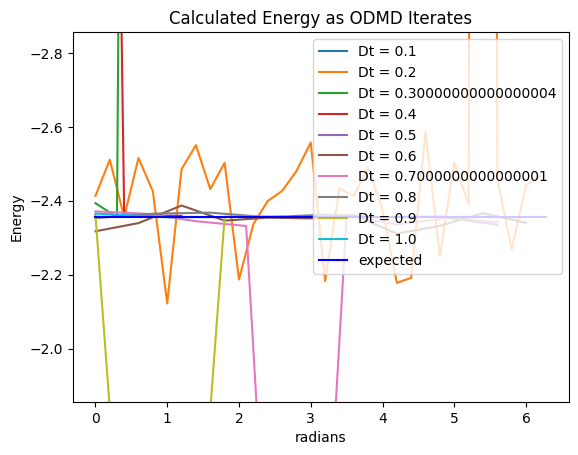

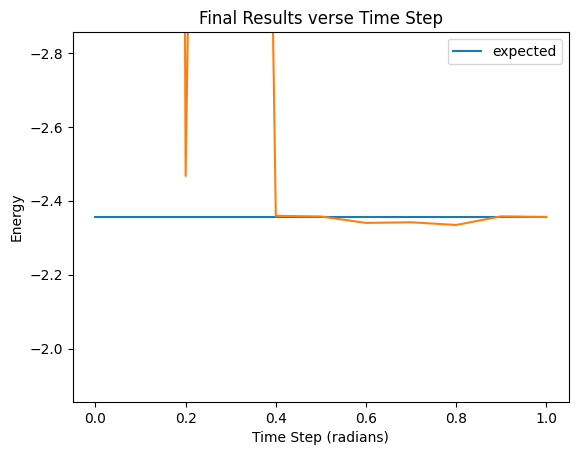

In [56]:
time_steps = np.arange(.1, 1.1, .1)
real_E_0 = -abs(np.linalg.eigvals(Ham)[0].real)


for i in range(len(trials)):
    plt.plot(np.arange(0, 2*pi, time_steps[i])[0:len(trials[i])], trials[i], label = 'Dt = '+str(time_steps[i]))
plt.title("Calculated Energy as ODMD Iterates")
plt.ylabel("Energy")
plt.xlabel("radians")
plt.plot([0, 2*pi], [real_E_0, real_E_0], label = "expected", c = 'b')
plt.legend()
plt.ylim([-abs(np.linalg.eigvals(Ham)[0].real)+.5,-abs(np.linalg.eigvals(Ham)[0].real)-.5])
plt.show()

plt.title("Final Results verse Time Step")
plt.xlabel("Time Step (radians)")
plt.ylabel("Energy")
plt.plot([0, time_steps[-1]], [real_E_0, real_E_0], label = "expected",)
plt.plot(time_steps, results)
plt.ylim([-abs(np.linalg.eigvals(Ham)[0].real)+.5,-abs(np.linalg.eigvals(Ham)[0].real)-.5])

plt.legend()
plt.show()